In [0]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm # progress bar

import torch.backends.cudnn as cudnn # tuninig
from IPython.display import clear_output
import random 

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")     #Check whether a GPU is present.

In [0]:
device

device(type='cuda', index=0)

# Loading Data

# Generator

## Model

In [0]:
class GeneratorNet(torch.nn.Module):
  
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.layer1 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.layer2 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.out(x)
        return x
    


## loading generators

In [0]:
generator_MNIST = GeneratorNet()

In [0]:
generator_FASHION = GeneratorNet()

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
model_save_name = 'GAN_MNIST.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/ComputerVision/MNIST/{model_save_name}" 
checkpoint = torch.load(path)
generator_MNIST.load_state_dict(checkpoint['generator_state_dict'])
noise_MNIST = checkpoint["test_noise"]

In [0]:
model_save_name = 'GAN_FASHION.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/ComputerVision/MNIST/{model_save_name}" 
checkpoint = torch.load(path)
generator_FASHION.load_state_dict(checkpoint['generator_state_dict'])
noise_FASHION_MNIST = checkpoint["test_noise"]

In [0]:
with torch.no_grad():
    sample = Variable(torch.randn(16, 100))
    sample = (generator_MNIST(sample.to(device))+1)/2
    save_name = "sample_test.png"
    save_image(sample.view(16, 1, 28, 28),
              F"/content/gdrive/My Drive/Colab Notebooks/ComputerVision/MNIST/results(class)/{save_name}")

RuntimeError: ignored

In [0]:
generator_MNIST.to(device)
generator_FASHION.to(device)

GeneratorNet(
  (layer1): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (layer2): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (layer3): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (out): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
)

In [0]:
sample.size()

torch.Size([16, 784])

# AutoEncoder

## Model

In [0]:
# Writing our model
class Autoencoder(nn.Module):
    def __init__(self, generator):
        super(Autoencoder,self).__init__()
        self.decoder = generator.eval()

        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(True),
            nn.Linear(256, 100)
            )


    def forward(self,x):
        x = self.encoder(x.view(x.size()[0],784)).view(x.size()[0],100)
        x = self.decoder(x).view(x.size()[0],1,28,28)
        return x

## loading ae

In [0]:
autoencoder_FASHION = Autoencoder(generator_FASHION)
autoencoder_FASHION.to(device)

Autoencoder(
  (decoder): GeneratorNet(
    (layer1): Sequential(
      (0): Linear(in_features=100, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (layer2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (layer3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (out): Sequential(
      (0): Linear(in_features=1024, out_features=784, bias=True)
      (1): Tanh()
    )
  )
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=100, bias=True)
  )
)

In [0]:
autoencoder_MNIST = Autoencoder(generator_MNIST)
autoencoder_MNIST.to(device)


Autoencoder(
  (decoder): GeneratorNet(
    (layer1): Sequential(
      (0): Linear(in_features=100, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (layer2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (layer3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (out): Sequential(
      (0): Linear(in_features=1024, out_features=784, bias=True)
      (1): Tanh()
    )
  )
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=100, bias=True)
  )
)

In [0]:
model_save_name = 'AE_MNIST2.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/ComputerVision/MNIST/results(AE)/saveAE" 
checkpoint = torch.load(path)
autoencoder_MNIST.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [0]:
model_save_name = 'AE_FASHION3.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/ComputerVision/MNIST/results(AE_Fashion)/saveAE_fashion"
checkpoint = torch.load(path)
autoencoder_FASHION.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [0]:
# 
distance = nn.MSELoss()

def test(epoch, model, test_sample):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        
        data = test_sample.to(device)
        recon_batch = model(data)

        test_loss += distance(recon_batch, data)

        n = min(data.size(0), 8)
        comparison = torch.cat([data[:n],
                              recon_batch.view(16, 1, 28, 28)[:n]])
        save_name = "reconstruction_" + str(epoch) + ".png"
        save_image((comparison.cpu()+1) / 2,
                  F"/content/gdrive/My Drive/Colab Notebooks/ComputerVision/MNIST/results(class)/{save_name}", nrow=n)
    
    test_loss /= 16
    print('Test set loss: {:.4f}'.format(test_loss))


In [0]:
test(0, autoencoder_MNIST, test_MNIST)

Test set loss: 0.0023


In [0]:
test(1, autoencoder_FASHION, test_MNIST)

Test set loss: 0.0194


In [0]:
test(2, autoencoder_MNIST, test_FASHION_MNIST)

Test set loss: 0.0218


In [0]:
test(3, autoencoder_FASHION, test_FASHION_MNIST)

Test set loss: 0.0014


# Classificator

## Classificator Model

In [0]:
# Writing our model
class Net(nn.Module):
    def __init__(self, number_classes):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=9),
            nn.ReLU(True),
            nn.Conv2d(6, 6, kernel_size=7),
            nn.ReLU(True),
            nn.Conv2d(6,6,kernel_size=5),
            nn.ReLU(True)
            )
        self.out = nn.Sequential(
            nn.Linear(600, number_classes, bias=True),
            nn.Softmax(dim=1)
        )
        
    def forward(self,x):
        x = self.conv(x).view(x.size()[0],600)
        x = self.out(x)
        return x

## loading Classificator

In [0]:
classificator = Net(2)
classificator.to(device)
if device.type == 'cuda':
    classificator = torch.nn.DataParallel(classificator)
    cudnn.benchmark = True

In [0]:
model_save_name = 'Classificator.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/ComputerVision/MNIST/{model_save_name}" 
checkpoint = torch.load(path)
classificator.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

# Image Generation

In [0]:
def generate(quant=16):
  samples = []
  with torch.no_grad():
    sample = Variable(torch.randn(quant, 100))
    mnist = generator_MNIST(sample.to(device)).view(quant, 1, 28, 28)
    
    for im in mnist:
      samples.append([0,im])

    sample = Variable(torch.randn(quant, 100))
    fashion = generator_FASHION(sample.to(device)).view(quant, 1, 28, 28)

    for im in fashion:
      samples.append([1,im])

    random.shuffle(samples)

    targets = torch.LongTensor([row[0] for row in samples])
    x = torch.Tensor().to(device)
    for row in samples:
      x = torch.cat((x, row[1]), 0)

  return (targets, x.view(2*quant,1,28,28))

In [0]:
generate(16)[0]


tensor([1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 0])

# Check

In [0]:
classes = ["Digit","Clothes"]

In [0]:
labels, samples = generate(12)
samples = samples.to(device)

fig = plt.figure(figsize=(18, 12))
fig.tight_layout()
with torch.no_grad():
  output = classificator(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]

for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    print(output[num].cpu())
    plt.title(classes[labels[num]] + " == " + classes[pred[num]] )
    plt.axis('off')
    sample = sample.cpu().numpy()

    plt.imshow((sample[0]+1)/2) # np.transpose(sample, (1,2,0))

In [0]:
# Loading and Transforming data
transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
      ])

testset = tv.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=6, shuffle=True, num_workers=2)

testsetFashion = tv.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloaderFashion = torch.utils.data.DataLoader(testsetFashion, batch_size=6, shuffle=True, num_workers=2)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!




/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


In [0]:
x=next(iter(testloader))
y=next(iter(testloaderFashion))

tensor([1., 0.])
tensor([1., 0.])
tensor([1., 0.])
tensor([1., 0.])
tensor([1., 0.])
tensor([1., 0.])


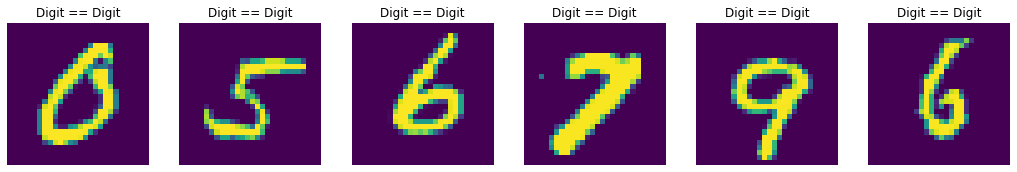

In [0]:
samples, labels  = x
samples = samples.to(device)
labels = labels * 0 

fig = plt.figure(figsize=(18, 12))
fig.tight_layout()
with torch.no_grad():
  output = classificator(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]

for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    print(output[num].cpu())
    plt.title(classes[labels[num]] + " == " + classes[pred[num]] )
    plt.axis('off')
    sample = sample.cpu().numpy()

    plt.imshow((sample[0]+1)/2) # np.transpose(sample, (1,2,0))

# IMG

In [0]:
transform1 = transforms.Compose(
    [transforms.Resize((28,28)),
     transforms.ToTensor(),
     transforms.Normalize((0.5),(0.5))
     ])

In [0]:
from PIL import Image

In [0]:
path = F"/content/gdrive/My Drive/Colab Notebooks/ComputerVision/MNIST/img/"

jpgfile = Image.open(path+"boot.jpg").convert('LA')
x= transform1(jpgfile)[0].view(1,1,28,28)
test = x/x.max()
test_boot = test

jpgfile = Image.open(path+"bag.jpg").convert('LA')
x= transform1(jpgfile)[0].view(1,1,28,28)
test = torch.cat((test, x/x.max()), 0)

jpgfile = Image.open(path+"nine.jpg").convert('LA')
x= transform1(jpgfile)[0].view(1,1,28,28)
test = torch.cat((test, x/x.max()), 0)

jpgfile = Image.open(path+"seven.jpg").convert('LA')
x= transform1(jpgfile)[0].view(1,1,28,28)
test = torch.cat((test, x/x.max()), 0)

jpgfile = Image.open(path+"eight.jpg").convert('LA')
x= transform1(jpgfile)[0].view(1,1,28,28)
test = torch.cat((test, x/x.max()), 0)

jpgfile = Image.open(path+"empty.jpg").convert('LA')
x= transform1(jpgfile)[0].view(1,1,28,28)
test = torch.cat((test, x/x.max()), 0)

test =0-test

test.size()

torch.Size([6, 1, 28, 28])

In [0]:
test[2].max()

tensor(1.)

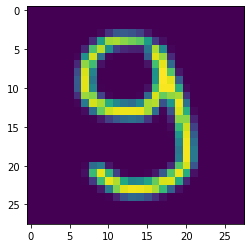

In [0]:
plt.imshow(test.numpy()[2][0])

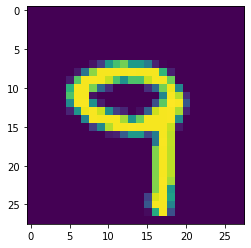

In [0]:
plt.imshow(x[0][0].numpy()[0])

In [0]:
labels = [1,1,0,0,0,0]
samples = test
samples = test.to(device)

fig = plt.figure(figsize=(20, 6))
fig.tight_layout()
with torch.no_grad():
  output = classificator(samples)
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]

for num, sample in enumerate(samples):
    plt.subplot(1,6,num+1)
    print(output[num].cpu())
    plt.title(classes[labels[num]] + " == " + classes[pred[num]] )
    plt.axis('off')
    sample = sample.cpu().numpy()

    plt.imshow(sample[0])#(sample[0]+1)/2) # np.transpose(sample, (1,2,0))

# Test Vector

In [0]:
  samples_vector = []
  with torch.no_grad():
    sample = Variable(torch.randn(2, 100))
    mnist = generator_MNIST(sample).view(2, 1, 28, 28)
    
    for im in mnist:
      samples_vector.append([0,im])

    
    digits_vector = torch.Tensor()
    for row in samples_vector:
      digits_vector = torch.cat((digits_vector, row[1]), 0)

vector = digits_vector[1] - digits_vector[0]

digits_list = torch.Tensor()
steps_vector = 21
for step in range(steps_vector+1):
    digits_list = torch.cat((digits_list,  digits_vector[0]+ step/steps_vector *vector), 0)


digits_list = digits_list.view(steps_vector+1,1,28,28)

tensor([1., 0.])
tensor([1., 0.])
tensor([1., 0.])
tensor([1., 0.])
tensor([1., 0.])
tensor([1., 0.])
tensor([1., 0.])
tensor([1., 0.])
tensor([1., 0.])
tensor([1., 0.])
tensor([1., 0.])
tensor([1., 0.])
tensor([1., 0.])
tensor([1., 0.])
tensor([1., 0.])
tensor([1., 0.])
tensor([1., 0.])
tensor([1., 0.])
tensor([1., 0.])
tensor([1., 0.])
tensor([1., 0.])
tensor([1., 0.])


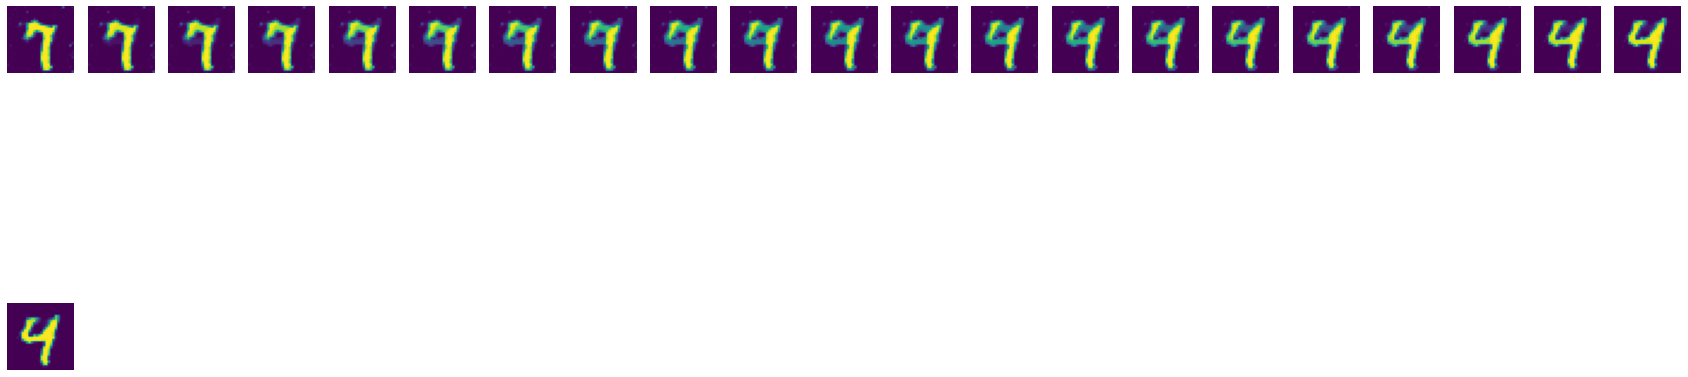

In [0]:
labels_vector = [0 for x in range(steps_vector+1)]

samples = digits_list.to(device)

fig = plt.figure(figsize=(30, 10))
fig.tight_layout()
with torch.no_grad():
  output = classificator(samples)
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]

for num, sample in enumerate(samples):
    plt.subplot(2,steps_vector+1//2,num+1)
    print(output[num].cpu())
    
    plt.axis('off')
    sample = sample.cpu().numpy()

    plt.imshow(sample[0])#(sample[0]+1)/2) # np.transpose(sample, (1,2,0))

# Main


In [0]:
x=next(iter(testloader))
y=next(iter(testloaderFashion))

In [0]:
class Video:
  def __init__(self, generator_list, autoencoder_list, classificator, classes_names):
    self.generators = generator_list
    self.autoencoders = autoencoder_list
    self.classificator = classificator
    self.classes = classes_names
  
  def __call__(self, img):
    with torch.no_grad():
      preidction_list = classificator(img)
      class_num = torch.argmax(preidction_list, dim=1)
      class_num = class_num.item()

    # fig = plt.figure(figsize=(30, 10))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(img.numpy()[0][0])

    with torch.no_grad():
      print(class_num)
      # if class_num==0:
      output = self.autoencoders[class_num].encoder(img.view((1,1,784)).to(device))
      # else:
      #   output = self.autoencoders[class_num].encoder(img.to(device))
      
    with torch.no_grad():

      plt.subplot(1,2,2)
      plt.title( classes[class_num] )
      plt.axis('off')
      decoded = self.autoencoders[class_num].decoder(output.view(1,100)).view(1,28,28)
      plt.imshow((decoded.cpu().numpy()[0]+1) /2)

    return output.cpu().numpy()




In [0]:
video = Video([generator_MNIST, generator_FASHION],[autoencoder_MNIST,autoencoder_FASHION],classificator,classes)

In [0]:
video(test[4].view((1,1,28,28)))

0


array([[[ 5.73310757e+00, -2.70706582e+00, -4.03479195e+00,
         -8.65293503e+00, -6.00313091e+00,  1.96208775e-01,
          1.20153749e+00, -8.31382990e-01,  7.40407372e+00,
         -3.90556479e+00,  9.28892517e+00, -2.26685739e+00,
         -5.12546349e+00,  5.46363211e+00,  2.46855497e+00,
          2.26587176e+00, -1.64099216e+01, -2.74815321e+00,
          1.02005196e+01, -3.85378814e+00, -1.61349354e+01,
          6.88184118e+00, -2.77363610e+00,  1.22230256e+00,
         -3.62802243e+00,  8.69331360e+00,  2.90651584e+00,
         -8.84852791e+00, -4.62972689e+00, -6.54626489e-01,
          2.08766365e+00,  4.48562801e-02, -4.92791474e-01,
         -1.56079543e+00,  4.31242514e+00, -1.70459747e+00,
         -4.58502293e+00, -9.78294849e+00, -1.47359300e+00,
         -1.21389055e+00, -3.36186790e+00,  3.20793688e-01,
          6.55991256e-01,  4.48450661e+00,  6.19055176e+00,
         -4.10953045e+00, -1.91354513e-01, -6.06580591e+00,
         -1.31078470e+00, -1.57320905e+0

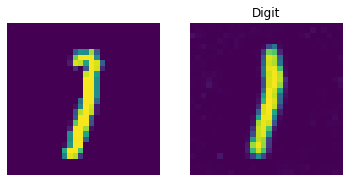

In [0]:
video(x[0][0].view((1,1,28,28)))

0


array([[[[1.0074058 , 0.        , 0.        , 0.09361529, 0.39216274,
          0.        , 0.21652663, 0.        , 0.72041076, 0.9740379 ],
         [0.18578294, 0.        , 0.        , 0.10193294, 0.        ,
          0.        , 0.        , 0.6352296 , 0.37933183, 0.00878125],
         [0.14919788, 0.        , 0.38180363, 0.        , 0.        ,
          0.        , 0.        , 0.48319626, 0.6328867 , 1.2927628 ],
         [0.07061875, 0.        , 0.06933582, 0.        , 0.        ,
          0.        , 0.21276364, 0.52462536, 1.2681438 , 0.12628534],
         [0.        , 0.16394177, 0.14843175, 0.5369578 , 0.        ,
          1.3263677 , 0.8151967 , 0.        , 0.1691764 , 0.        ],
         [0.        , 0.        , 1.2527459 , 0.0900265 , 1.206524  ,
          0.39113265, 0.        , 0.        , 0.2813262 , 0.6531564 ],
         [0.32913545, 0.9923447 , 1.7493231 , 0.01354229, 0.        ,
          0.5613167 , 1.2434859 , 1.8105948 , 1.3210158 , 0.679562  ],
         [1.9

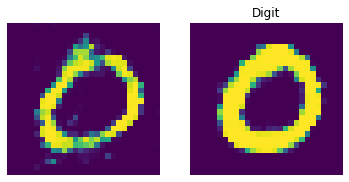

In [0]:
video(generate(1)[1][1].cpu().view((1,1,28,28)))


# Accuracy

In [0]:
correct = 0
with torch.no_grad():
  for inputs, targets in tqdm(testloader):
    output = classificator(inputs)
    _, predicted = output.max(1)

    correct += predicted.cpu().eq(targets*0).sum().item()
    
correct/10000

0.9995

In [0]:
correct = 0
with torch.no_grad():
  for inputs, targets in tqdm(testloaderFashion):
    output = classificator(inputs)
    _, predicted = output.max(1)

    correct += predicted.cpu().eq(targets*0+1).sum().item()

correct/10000

0.976

In [0]:
classificator.train()
loss = 0
correct = 0
total = 0
with torch.no_grad:
  output = classificator(samples[:24])
  for step in tqdm(range(size)):
      step += 1
      targets, inputs  = generate(16)
      inputs, targets  = inputs.to(device), targets.to(device)

      optimizer.zero_grad()
      outputs = classificator(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()

      loss += loss.item()
      _, predicted = outputs.max(1)
      total += targets.size(0)
      correct += predicted.eq(targets).sum().item()

  train_loss.append(loss/(step+1))
  print('Loss: {0:3f} | Acc: {1:3f} ({2:d}/{3:d})'.format(loss/(step+1), 100.*correct/total, correct, total))

# References

https://www.kaggle.com/pintu161/transfer-learning-in-pytorch-using-resnet18     very useful

https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py

https://github.com/townblack/pytorch-cifar10-resnet18/blob/master/train.py

https://github.com/kuangliu/pytorch-cifar/blob/master/main.py